# Define objects

In [2]:
import torch
import lovely_tensors as lt
import numpy as np
lt.monkey_patch()

def create_tomographic_phantom(N, device):
    """Create a simple tomographic phantom with geometric shapes"""
    # Create coordinate grids
    x = torch.linspace(-1, 1, N, device=device)
    y = torch.linspace(-1, 1, N, device=device)
    z = torch.linspace(-1, 1, N, device=device)
    X, Y, Z = torch.meshgrid(x, y, z, indexing='ij')
    
    # Initialize phantom
    phantom = torch.zeros(N, N, N, device=device, dtype=torch.float32)
    
    # Add a large sphere (background object)
    r_sphere = torch.sqrt(X**2 + Y**2 + Z**2)
    phantom += 0.3 * (r_sphere < 0.8).float()
    
    # Add a smaller high-density sphere
    r_small = torch.sqrt((X - 0.3)**2 + (Y - 0.2)**2 + (Z - 0.1)**2)
    phantom += 0.7 * (r_small < 0.2).float()
    
    # Add an ellipsoid
    ellipse = ((X + 0.3)**2/0.15**2 + (Y - 0.3)**2/0.25**2 + (Z + 0.2)**2/0.1**2)
    phantom += 0.5 * (ellipse < 1.0).float()
    
    # Add some cylindrical structures
    r_cyl = torch.sqrt(X**2 + (Y + 0.4)**2)
    phantom += 0.4 * ((r_cyl < 0.15) & (torch.abs(Z) < 0.6)).float()
    
    return phantom

# vol: [1,1,N,N,N], normals: [K,3]
N = 32
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Create a single tomographic phantom
phantom = create_tomographic_phantom(N, device)

# Create tensor_vol by replicating the phantom 1000 times (10x10x10)
tensor_vol = phantom.unsqueeze(0).unsqueeze(0).unsqueeze(0).expand(10, 10, 10, N, N, N).contiguous()

print(f"Created tensor_vol with shape: {tensor_vol.shape}")
print(f"Phantom value range: [{phantom.min():.3f}, {phantom.max():.3f}]")
tensor_vol

Created tensor_vol with shape: torch.Size([10, 10, 10, 32, 32, 32])
Phantom value range: [0.000, 1.000]


tensor[10, 10, 10, 32, 32, 32] n=32768000 (0.1Gb) x∈[0., 1.000] μ=0.080 σ=0.153

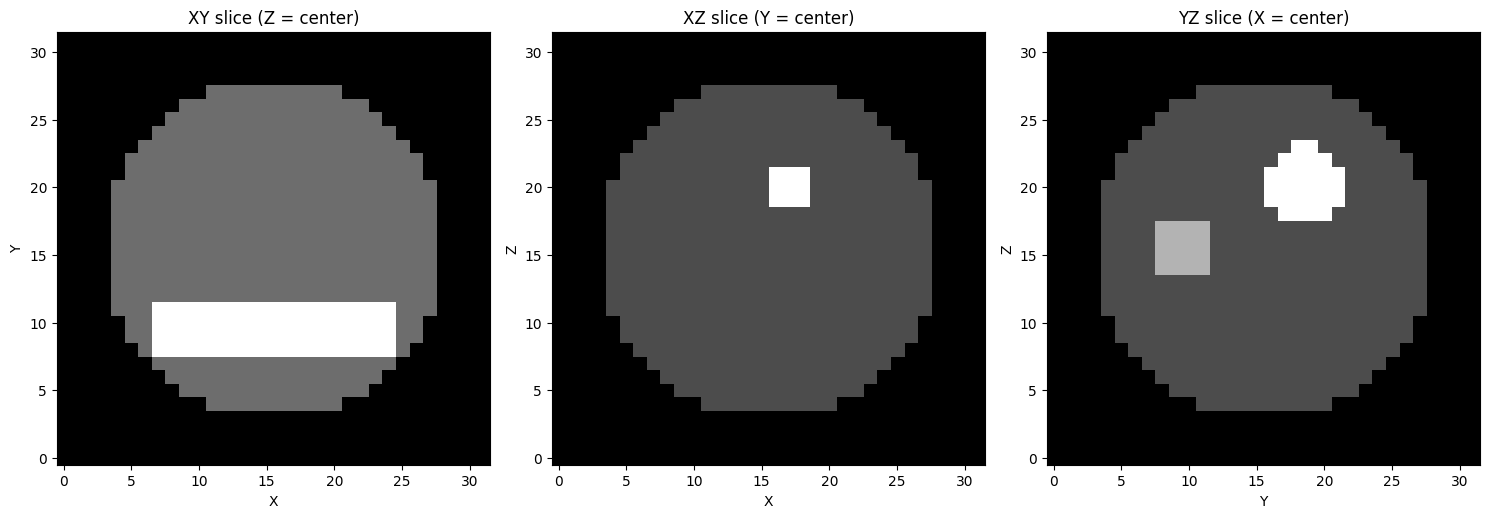

Phantom statistics:
  Shape: torch.Size([32, 32, 32])
  Min value: 0.000
  Max value: 1.000
  Mean value: 0.080
  Non-zero voxels: 8024/32768 (24.5%)


In [3]:
# Visualize the tomographic phantom
import matplotlib.pyplot as plt

# Show three orthogonal slices through the center of the phantom
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# XY slice (through center in Z)
axes[0].imshow(phantom[N//2, :, :].cpu().numpy(), cmap='gray', origin='lower')
axes[0].set_title('XY slice (Z = center)')
axes[0].set_xlabel('X')
axes[0].set_ylabel('Y')

# XZ slice (through center in Y)
axes[1].imshow(phantom[:, N//2, :].cpu().numpy(), cmap='gray', origin='lower')
axes[1].set_title('XZ slice (Y = center)')
axes[1].set_xlabel('X')
axes[1].set_ylabel('Z')

# YZ slice (through center in X)
axes[2].imshow(phantom[:, :, N//2].cpu().numpy(), cmap='gray', origin='lower')
axes[2].set_title('YZ slice (X = center)')
axes[2].set_xlabel('Y')
axes[2].set_ylabel('Z')

plt.tight_layout()
plt.show()

print(f"Phantom statistics:")
print(f"  Shape: {phantom.shape}")
print(f"  Min value: {phantom.min():.3f}")
print(f"  Max value: {phantom.max():.3f}")
print(f"  Mean value: {phantom.mean():.3f}")
print(f"  Non-zero voxels: {(phantom > 0).sum().item()}/{phantom.numel()} ({100*(phantom > 0).sum().item()/phantom.numel():.1f}%)")

In [4]:
def generate_intersecting_rays(k: int, device=None, dtype=torch.float32):
    """
    Generate k random rays that intersect the volume [-1, 1]^3.
    
    Args:
        k: number of rays to generate
        device: torch device (cuda/cpu)
        dtype: tensor dtype
    
    Returns:
        r0: (k, 3) tensor of ray origins
        d: (k, 3) tensor of ray directions (normalized)
    """
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # Strategy: Generate rays that are guaranteed to intersect [-1,1]^3
    # We'll use a mix of strategies to get good coverage
    
    rays_origins = []
    rays_directions = []
    
    # Strategy 1: Rays starting from inside the cube (30% of rays)
    k1 = int(0.3 * k)
    if k1 > 0:
        # Origins inside [-1,1]^3
        r0_inside = torch.rand(k1, 3, device=device, dtype=dtype) * 2 - 1  # [-1,1]^3
        # Random directions
        d_inside = torch.randn(k1, 3, device=device, dtype=dtype)
        d_inside = d_inside / torch.norm(d_inside, dim=1, keepdim=True)
        
        rays_origins.append(r0_inside)
        rays_directions.append(d_inside)
    
    # Strategy 2: Rays from cube faces pointing inward (40% of rays)
    k2 = int(0.4 * k)
    if k2 > 0:
        face_origins = []
        face_directions = []
        
        for i in range(k2):
            # Choose a random face (6 faces total)
            face = torch.randint(0, 6, (1,)).item()
            axis = face // 2  # 0=x, 1=y, 2=z
            sign = 1 if face % 2 == 0 else -1  # positive or negative face
            
            # Create origin on the face
            r0_face = torch.rand(3, device=device, dtype=dtype) * 2 - 1  # [-1,1]^3
            r0_face[axis] = sign  # place on face
            
            # Create direction pointing somewhat toward the cube center
            center = torch.zeros(3, device=device, dtype=dtype)
            to_center = center - r0_face
            
            # Add some randomness to the direction
            random_dir = torch.randn(3, device=device, dtype=dtype) * 0.5
            d_face = to_center + random_dir
            d_face = d_face / torch.norm(d_face)
            
            face_origins.append(r0_face)
            face_directions.append(d_face)
        
        if face_origins:
            rays_origins.append(torch.stack(face_origins))
            rays_directions.append(torch.stack(face_directions))
    
    # Strategy 3: Rays from outside pointing toward cube (30% of rays)
    k3 = k - k1 - k2  # remaining rays
    if k3 > 0:
        # Origins outside [-1,1]^3 but not too far
        r0_outside = torch.randn(k3, 3, device=device, dtype=dtype) * 3  # broader range
        # Ensure they're outside [-1,1]^3
        mask = (r0_outside.abs() <= 1).all(dim=1)
        while mask.any():
            # Replace origins that are inside
            new_origins = torch.randn(mask.sum(), 3, device=device, dtype=dtype) * 4
            r0_outside[mask] = new_origins
            mask = (r0_outside.abs() <= 1).all(dim=1)
        
        # Directions pointing toward the cube center with some randomness
        center = torch.zeros(3, device=device, dtype=dtype)
        to_center = center - r0_outside
        
        # Add randomness but bias toward center
        random_component = torch.randn(k3, 3, device=device, dtype=dtype) * 0.3
        d_outside = to_center + random_component
        d_outside = d_outside / torch.norm(d_outside, dim=1, keepdim=True)
        
        rays_origins.append(r0_outside)
        rays_directions.append(d_outside)
    
    # Concatenate all rays
    r0 = torch.cat(rays_origins, dim=0)
    d = torch.cat(rays_directions, dim=0)
    
    # Shuffle to mix strategies
    perm = torch.randperm(k, device=device)
    r0 = r0[perm]
    d = d[perm]
    
    return r0, d


def verify_ray_intersection(r0, d, box_min=-1, box_max=1):
    """
    Verify that rays intersect the box [box_min, box_max]^3
    
    Args:
        r0: (k, 3) ray origins
        d: (k, 3) ray directions
        box_min, box_max: box bounds
        
    Returns:
        intersects: (k,) boolean tensor indicating which rays intersect
        t_entry: (k,) entry parameter (nan for non-intersecting rays)
        t_exit: (k,) exit parameter (nan for non-intersecting rays)
    """
    k = r0.shape[0]
    device = r0.device
    
    bounds_min = torch.tensor([box_min, box_min, box_min], device=device, dtype=r0.dtype)
    bounds_max = torch.tensor([box_max, box_max, box_max], device=device, dtype=r0.dtype)
    
    t_entries = []
    t_exits = []
    
    for i in range(3):  # for each axis
        # Avoid division by zero
        parallel_mask = d[:, i].abs() < 1e-6
        
        t1 = torch.full((k,), float('inf'), device=device, dtype=r0.dtype)
        t2 = torch.full((k,), float('-inf'), device=device, dtype=r0.dtype)
        
        # Only compute for non-parallel rays
        non_parallel = ~parallel_mask
        if non_parallel.any():
            t1[non_parallel] = (bounds_min[i] - r0[non_parallel, i]) / d[non_parallel, i]
            t2[non_parallel] = (bounds_max[i] - r0[non_parallel, i]) / d[non_parallel, i]
        
        # For parallel rays, check if they're inside the slab
        if parallel_mask.any():
            inside_slab = (r0[parallel_mask, i] >= bounds_min[i]) & (r0[parallel_mask, i] <= bounds_max[i])
            t1[parallel_mask] = torch.where(inside_slab, 
                                          torch.tensor(float('-inf'), device=device, dtype=r0.dtype),
                                          torch.tensor(float('inf'), device=device, dtype=r0.dtype))
            t2[parallel_mask] = torch.where(inside_slab,
                                          torch.tensor(float('inf'), device=device, dtype=r0.dtype), 
                                          torch.tensor(float('-inf'), device=device, dtype=r0.dtype))
        
        t_entries.append(torch.min(t1, t2))
        t_exits.append(torch.max(t1, t2))
    
    # Overall intersection
    t_entry = torch.stack(t_entries, dim=1).max(dim=1)[0]  # max of all entries
    t_exit = torch.stack(t_exits, dim=1).min(dim=1)[0]     # min of all exits
    
    # Ray intersects if t_entry <= t_exit
    intersects = t_entry <= t_exit
    
    # Set non-intersecting rays to nan
    t_entry = torch.where(intersects, t_entry, torch.tensor(float('nan'), device=device, dtype=r0.dtype))
    t_exit = torch.where(intersects, t_exit, torch.tensor(float('nan'), device=device, dtype=r0.dtype))
    
    return intersects, t_entry, t_exit


# Generate and test rays
N_rays = 20
print(f"Generating {N_rays} random rays intersecting [-1,1]^3...")

r0, ray_directions = generate_intersecting_rays(N_rays, device=device) # r0: (k,3), d: (k,3)
intersects, t_entry, t_exit = verify_ray_intersection(r0, ray_directions)

print(f"Ray origins shape: {r0.shape}")
print(f"Ray directions shape: {ray_directions.shape}")
print(f"Intersection success rate: {intersects.float().mean():.3f}")
print(f"Ray origins range: [{r0.min():.2f}, {r0.max():.2f}]")
print(f"Ray directions are normalized: {torch.allclose(torch.norm(ray_directions, dim=1), torch.ones(N_rays, device=device), rtol=1e-5)}")

# Show some examples
print(f"\nFirst 5 rays:")
for i in range(5):
    print(f"  Ray {i}: r0={r0[i].cpu().numpy()}, d={ray_directions[i].cpu().numpy()}, intersects={intersects[i].item()}")
    if intersects[i]:
        print(f"          t_entry={t_entry[i]:.3f}, t_exit={t_exit[i]:.3f}")

Generating 20 random rays intersecting [-1,1]^3...
Ray origins shape: torch.Size([20, 3])
Ray directions shape: torch.Size([20, 3])
Intersection success rate: 1.000
Ray origins range: [-3.97, 4.69]
Ray directions are normalized: True

First 5 rays:
  Ray 0: r0=[ 2.160563    4.6868725  -0.49123108], d=[-0.37641162 -0.92620057 -0.0216051 ], intersects=True
          t_entry=3.981, t_exit=6.140
  Ray 1: r0=[-1.7607704 -1.132916  -2.314623 ], d=[0.4230078  0.22239198 0.8784112 ], intersects=True
          t_entry=1.798, t_exit=3.773
  Ray 2: r0=[-1.         0.610167  -0.6075908], d=[ 0.6256783  -0.61342317  0.48191148], intersects=True
          t_entry=0.000, t_exit=2.625
  Ray 3: r0=[ 0.67273617 -0.9276403   0.39227772], d=[ 0.00219099  0.21941403 -0.9756294 ], intersects=True
          t_entry=-0.330, t_exit=1.427
  Ray 4: r0=[-0.14243472  0.51671433 -0.3363154 ], d=[-0.6657966 -0.7368485  0.1173424], intersects=True
          t_entry=-0.656, t_exit=1.288


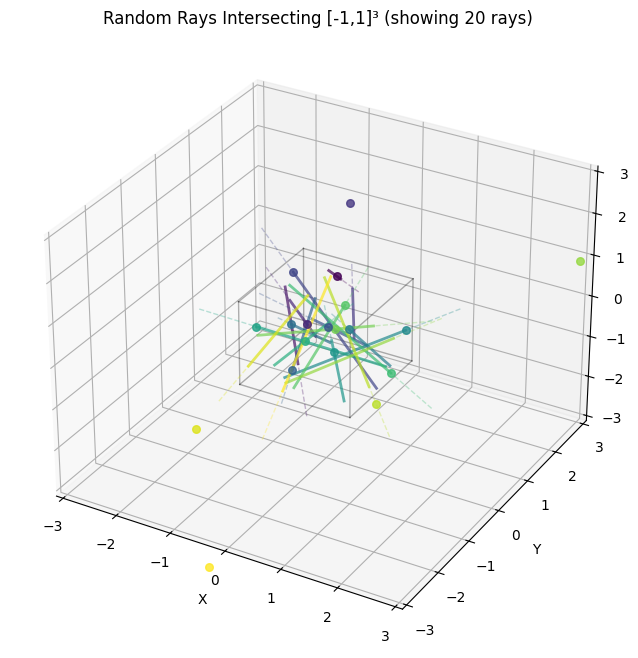

In [5]:
# Visualize the generated rays
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D

def visualize_rays_3d(r0, d, t_entry, t_exit, num_rays=20):
    """Visualize a subset of the generated rays"""
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')
    
    # Draw the cube [-1,1]^3
    cube_edges = [
        # Bottom face
        [[-1,-1,-1], [1,-1,-1]], [[-1,-1,-1], [-1,1,-1]], 
        [[1,-1,-1], [1,1,-1]], [[-1,1,-1], [1,1,-1]],
        # Top face  
        [[-1,-1,1], [1,-1,1]], [[-1,-1,1], [-1,1,1]],
        [[1,-1,1], [1,1,1]], [[-1,1,1], [1,1,1]],
        # Vertical edges
        [[-1,-1,-1], [-1,-1,1]], [[1,-1,-1], [1,-1,1]],
        [[-1,1,-1], [-1,1,1]], [[1,1,-1], [1,1,1]]
    ]
    
    for edge in cube_edges:
        edge = torch.tensor(edge)
        ax.plot3D(edge[:,0], edge[:,1], edge[:,2], 'k-', alpha=0.3, linewidth=1)
    
    # Sample some rays to visualize
    indices = torch.randperm(r0.shape[0])[:num_rays]
    
    colors = plt.cm.viridis(np.linspace(0, 1, num_rays))
    
    for i, idx in enumerate(indices):
        r0_i = r0[idx].cpu().numpy()
        d_i = d[idx].cpu().numpy()
        t_entry_i = t_entry[idx].cpu().numpy()
        t_exit_i = t_exit[idx].cpu().numpy()
        
        if not np.isnan(t_entry_i) and not np.isnan(t_exit_i):
            # Entry and exit points
            p_entry = r0_i + t_entry_i * d_i
            p_exit = r0_i + t_exit_i * d_i
            
            # Draw ray segment inside cube
            ax.plot3D([p_entry[0], p_exit[0]], [p_entry[1], p_exit[1]], [p_entry[2], p_exit[2]], 
                     color=colors[i], alpha=0.7, linewidth=2)
            
            # Draw ray origin
            ax.scatter(*r0_i, color=colors[i], s=30, alpha=0.8)
            
            # Extend ray outside cube for visualization
            t_extend = max(-3, t_entry_i - 1)
            p_extend = r0_i + t_extend * d_i
            ax.plot3D([p_extend[0], p_entry[0]], [p_extend[1], p_entry[1]], [p_extend[2], p_entry[2]], 
                     color=colors[i], alpha=0.3, linewidth=1, linestyle='--')
    
    ax.set_xlabel('X')
    ax.set_ylabel('Y')  
    ax.set_zlabel('Z')
    ax.set_title(f'Random Rays Intersecting [-1,1]³ (showing {num_rays} rays)')
    
    # Set equal aspect ratio
    ax.set_xlim([-3, 3])
    ax.set_ylim([-3, 3])
    ax.set_zlim([-3, 3])
    
    plt.show()

# Visualize the rays
visualize_rays_3d(r0, ray_directions, t_entry, t_exit, num_rays=20)

# Central plane slices

In [6]:
import torch
import torch.nn.functional as F


def central_plane_slices(
    vol: torch.Tensor,          # [B, C, N, N, N] on GPU
    normals: torch.Tensor,      # [B, 3] on same device/dtype as vol
    out_size: int | None = None,
    mask_circle: bool = True,
    mode: str = "bilinear",     # 'bilinear' gives trilinear in 3D
    align_corners: bool = False
):
    """
    Returns central plane slices orthogonal to each normal in `normals`.
    vol:      [B, C, N, N, N]
    normals:  [B, 3] (need not be unit length)
    out:      [B, C, S, S] where S = out_size or N
    """
    assert vol.dim() == 5, "vol must be [B, C, N, N, N]"
    B, C, N, _, _ = vol.shape
    device = vol.device
    dtype  = vol.dtype
    S = out_size or N
    r = (N - 1) / 2.0  # half-extent in index units

    # Normalize normals
    v = F.normalize(normals.to(device=device, dtype=dtype), dim=-1, eps=1e-12)  # [B,3]

    # Build an orthonormal basis (u, w, v) with u,w in plane, v = normal
    # Choose a reference not colinear with v to start Gram-Schmidt
    ref = torch.tensor([1.0, 0.0, 0.0], device=device, dtype=dtype).expand(B, 3).clone()
    swap_mask = (v.abs()[:, 0] > 0.9)  # if v ~ x-axis, use y-axis as ref
    ref[swap_mask] = torch.tensor([0.0, 1.0, 0.0], device=device, dtype=dtype)

    # --- build orthonormal basis (same as before) ---
    u = ref - (ref * v).sum(dim=-1, keepdim=True) * v
    u = F.normalize(u, dim=-1, eps=1e-12)        # [B,3]
    w = torch.cross(v, u, dim=-1)                # [B,3]

    # --- 2D plane grid (xi, eta) ---
    xi  = torch.linspace(-r, r, steps=S, device=device, dtype=dtype)   # [S]
    eta = torch.linspace(-r, r, steps=S, device=device, dtype=dtype)   # [S]
    XI, ETA = torch.meshgrid(xi, eta, indexing="ij")                   # [S,S]

    # Make them batch-shaped so broadcasting hits [B, 1, 1] properly
    XIe  = XI.unsqueeze(0).expand(B, -1, -1)      # [B,S,S]
    ETAe = ETA.unsqueeze(0).expand(B, -1, -1)     # [B,S,S]

    # Take per-batch scalar components of u,w and broadcast to [B,S,S]
    ux, uy, uz = u[:, 0].view(B,1,1), u[:, 1].view(B,1,1), u[:, 2].view(B,1,1)  # [B,1,1]
    wx, wy, wz = w[:, 0].view(B,1,1), w[:, 1].view(B,1,1), w[:, 2].view(B,1,1)  # [B,1,1]

    # Center in voxel index coords
    cx = cy = cz = r

    # Coordinates in voxel index space, final shape [B,S,S]
    X = cx + XIe * ux + ETAe * wx
    Y = cy + XIe * uy + ETAe * wy
    Z = cz + XIe * uz + ETAe * wz

    # Stack to [B,S,S,3] in (x,y,z) order
    coords = torch.stack([X, Y, Z], dim=-1)       # [B,S,S,3]

    # Convert to grid_sample normalized coords in [-1, 1]
    # mapping idx -> norm:  norm = (idx / r) - 1  if align_corners=False and r=(N-1)/2
    norm_coords = (coords / r) - 1.0  # [B,S,S,3], order = x,y,z

    # grid_sample for 3D expects grid shaped [B, out_D, out_H, out_W, 3]
    # Here we want a single-plane (out_D=1). We can place the 2D grid into HW and use D=1.
    grid = norm_coords[:, None, :, :, :]  # [B,1,S,S,3]
    # But ordering for 3D grid is (z,y,x). Rearrange:
    grid = grid[..., [2, 1, 0]]  # to (z, y, x)

    # Sample: input [B,C,D,H,W], grid [B, out_D, out_H, out_W, 3]
    # out is [B,C,1,S,S]
    slice3d = F.grid_sample(
        vol, grid, mode=mode, align_corners=align_corners, padding_mode="zeros"
    )
    slices = slice3d[:, :, 0, :, :]  # [B,C,S,S]

    if mask_circle:
        RR2 = XI**2 + ETA**2  # [S,S]
        mask = (RR2 <= (r * r)).to(dtype=dtype, device=device)  # 1 inside circle
        slices = slices * mask[None, None, :, :]  # broadcast to [B,C,S,S]

    return slices  # [B,C,S,S]

One potential issue is that for each ray_direction, we would need to match the voxels with the direction that we want, right now it is computing all directions for all selected voxels.

In [7]:
# testing the central_plane_slices function with a random subset of 10 elements from tensor_vol
tensor_vol_indices = torch.randperm(np.prod(tensor_vol.shape[0:3]))[:10]
vol = tensor_vol.reshape(-1, *tensor_vol.shape[-3:])[tensor_vol_indices].unsqueeze(0)  # [1,1,N,N,N]

normals = ray_directions 
vol = vol.expand(normals.shape[0], -1, -1, -1, -1).contiguous()   # [K,1,N,N,N]
slices = central_plane_slices(vol, normals, out_size=N, mask_circle=True)  # [K,1,N,N]
slices

tensor[20, 10, 32, 32] n=204800 (0.8Mb) x∈[0., 1.000] μ=0.150 σ=0.186

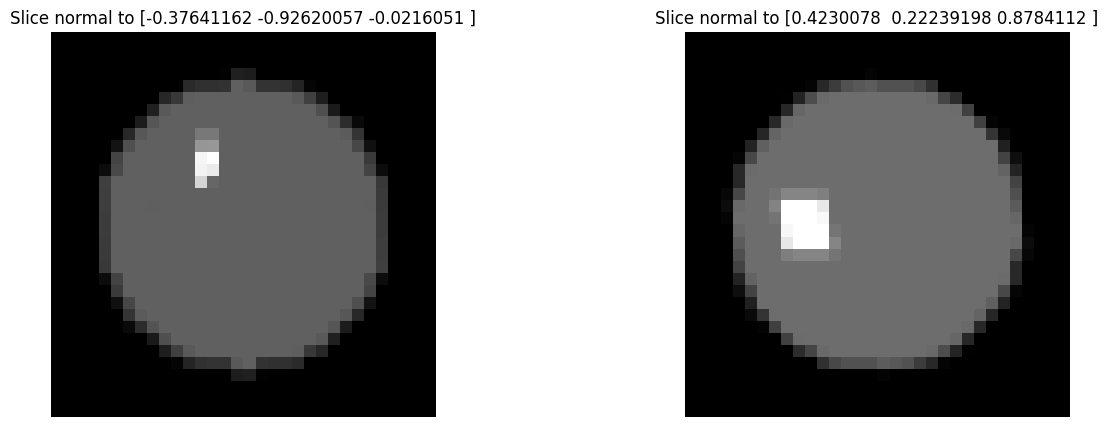

In [8]:
import matplotlib.pyplot as plt
# plot both slices side to side for visual check
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.imshow(slices[0,0].cpu(), cmap="gray")
plt.title(f"Slice normal to {ray_directions[0].cpu().numpy()}") 
plt.axis("off")
plt.subplot(1,2,2)
plt.imshow(slices[1,0].cpu(), cmap="gray")
plt.title(f"Slice normal to {ray_directions[1].cpu().numpy()}")
plt.axis("off")
plt.show()


# Ray Sampling

In [9]:
import torch

def batched_sample_ray_points(r0: torch.Tensor, d: torch.Tensor, K=50):
    """
    Batch version of sample_ray_points for multiple rays.
    
    Args:
        r0 : (k, 3) tensor, ray starts in world coords (x,y,z)
        d  : (k, 3) tensor, directions (not necessarily normalized)
        vol_bounds : tuple (min, max) defining the volume bounds [-1,1]^3 by default
        K  : number of samples per ray
    
    Returns:
        torch.Tensor: (k, K, 3) tensor of normalized sample points for grid_sample
    """
    vol_bounds=(-1, 1)
    k = r0.shape[0]
    device = r0.device
    dtype = r0.dtype
    vol_min, vol_max = vol_bounds
    
    # Normalize directions
    d = d / torch.norm(d, dim=1, keepdim=True)  # (k, 3)
    
    # Define bounding box for [-1,1]^3 (or custom bounds)
    bounds_min = torch.tensor([vol_min, vol_min, vol_min], device=device, dtype=dtype)  # (3,)
    bounds_max = torch.tensor([vol_max, vol_max, vol_max], device=device, dtype=dtype)  # (3,)
    
    # Initialize t bounds for all rays
    tmin = torch.full((k,), -1e9, device=device, dtype=dtype)  # (k,)
    tmax = torch.full((k,), 1e9, device=device, dtype=dtype)   # (k,)
    
    # Compute intersection for each axis
    for i in range(3):  # x, y, z axes
        lo, hi = bounds_min[i], bounds_max[i]
        
        # Handle parallel rays (avoid division by zero)
        parallel_mask = d[:, i].abs() < 1e-6
        
        # Compute t values for non-parallel rays
        t1 = torch.full((k,), float('inf'), device=device, dtype=dtype)
        t2 = torch.full((k,), float('-inf'), device=device, dtype=dtype)
        
        non_parallel = ~parallel_mask
        if non_parallel.any():
            t1[non_parallel] = (lo - r0[non_parallel, i]) / d[non_parallel, i]
            t2[non_parallel] = (hi - r0[non_parallel, i]) / d[non_parallel, i]
        
        # For parallel rays, check if they're inside the slab
        if parallel_mask.any():
            inside_slab = (r0[parallel_mask, i] >= lo) & (r0[parallel_mask, i] <= hi)
            t1[parallel_mask] = torch.where(inside_slab, 
                                          torch.tensor(float('-inf'), device=device, dtype=dtype),
                                          torch.tensor(float('inf'), device=device, dtype=dtype))
            t2[parallel_mask] = torch.where(inside_slab,
                                          torch.tensor(float('inf'), device=device, dtype=dtype), 
                                          torch.tensor(float('-inf'), device=device, dtype=dtype))
        
        # Find entry and exit t for this axis
        t_entry = torch.min(t1, t2)  # (k,)
        t_exit = torch.max(t1, t2)   # (k,)
        
        # Update overall bounds
        tmin = torch.max(tmin, t_entry)  # (k,)
        tmax = torch.min(tmax, t_exit)   # (k,)
    
    # Handle rays that don't intersect (tmin > tmax)
    valid_rays = tmin <= tmax
    
    # For invalid rays, set to dummy values (will be zeroed out later)
    tmin = torch.where(valid_rays, tmin, torch.tensor(0., device=device, dtype=dtype))
    tmax = torch.where(valid_rays, tmax, torch.tensor(0., device=device, dtype=dtype))
    
    # Sample K points along each ray
    # Create parameter values for all rays: (k, K)
    t_vals = torch.linspace(0, 1, K, device=device, dtype=dtype)[None, :].expand(k, K)  # (k, K)
    t_samples = tmin[:, None] + t_vals * (tmax[:, None] - tmin[:, None])  # (k, K)
    
    # Compute 3D points: (k, K, 3)
    # r0: (k, 3) -> (k, 1, 3), d: (k, 3) -> (k, 1, 3), t_samples: (k, K) -> (k, K, 1)
    pts = r0[:, None, :] + t_samples[:, :, None] * d[:, None, :]  # (k, K, 3)
    
    # Normalize to [-1, 1] for grid_sample
    # Since pts are already in world coords matching vol_bounds, we just need to normalize them
    normalized_pts = 2 * (pts - vol_min) / (vol_max - vol_min) - 1  # (k, K, 3)
    
    # Set invalid rays to zeros (or could use NaN)
    invalid_mask = ~valid_rays[:, None, None].expand(k, K, 3)
    normalized_pts = torch.where(invalid_mask, torch.tensor(0., device=device, dtype=dtype), normalized_pts)
    
    return normalized_pts  # (k, K, 3)


# Original single-ray function updated to work with [-1,1]^3 
def sample_ray_points(r0: torch.Tensor, d: torch.Tensor, K=50):
    """
    Original single-ray version updated for [-1,1]^3 volume.
    
    Args:
        r0 : (3,) tensor, ray start in world coords (x,y,z)  
        d  : (3,) tensor, direction (not necessarily normalized)
        vol_bounds : tuple (min, max) defining volume bounds
        K : number of samples
    """
    vol_bounds=(-1, 1)
    vol_min, vol_max = vol_bounds
    d = d / torch.norm(d)

    # compute entry/exit with box [vol_min, vol_max]^3
    bounds_min = torch.tensor([vol_min, vol_min, vol_min])
    bounds_max = torch.tensor([vol_max, vol_max, vol_max])

    tmin, tmax = -1e9, 1e9
    for i, (lo, hi) in enumerate(zip(bounds_min, bounds_max)):
        if abs(d[i]) < 1e-6:
            # Parallel ray - check if inside slab
            if r0[i] < lo or r0[i] > hi:
                # Outside slab, no intersection
                return torch.zeros(K, 3)  # Return zeros for no intersection
            continue
            
        t1 = (lo - r0[i]) / d[i]
        t2 = (hi - r0[i]) / d[i]
        tmin = max(tmin, min(t1, t2))
        tmax = min(tmax, max(t1, t2))

    # Check if ray intersects
    if tmin > tmax:
        return torch.zeros(K, 3)  # No intersection

    # sample K points between entry and exit
    ts = torch.linspace(tmin, tmax, K)
    pts = r0[None, :] + ts[:, None] * d[None, :]  # (K,3) in world coords

    # normalize to [-1,1] for grid_sample
    # pts are already in world coords matching vol_bounds
    normalized_pts = 2 * (pts - vol_min) / (vol_max - vol_min) - 1
    
    return normalized_pts  # (K,3)

In [10]:
# Test the batched ray sampling function with correct volume bounds
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D

# Test with our generated rays that intersect [-1,1]^3
K = 30

print("Testing batched ray sampling with [-1,1]³ volume...")
print(f"Input rays: r0.shape = {r0.shape}, ray_directions.shape = {ray_directions.shape}")

# Call the batched function with correct bounds
sampled_ray_points = batched_sample_ray_points(r0, ray_directions, K=K)

print(f"Batched output shape: {sampled_ray_points.shape}")
print(f"Expected shape: ({r0.shape[0]}, {K}, 3)")
print(f"Output range: [{sampled_ray_points.min():.3f}, {sampled_ray_points.max():.3f}]")

# Check if samples are non-zero (indicating successful intersection)
non_zero_samples = (sampled_ray_points.abs().sum(dim=-1) > 0).float()
success_rate = non_zero_samples.sum(dim=1) / K
print(f"Success rate per ray (non-zero samples): {success_rate.mean():.3f}")
print(f"Rays with >90% successful samples: {(success_rate > 0.9).float().mean():.3f}")

# Compare with single-ray version for the first few rays
print(f"\nComparison with single-ray function:")
for i in range(min(3, r0.shape[0])):
    single_sample = sample_ray_points(r0[i], ray_directions[i], K=K)
    batched_sample = sampled_ray_points[i]
    
    single_nonzero = (single_sample.abs().sum(dim=-1) > 0).float().sum()
    batched_nonzero = (batched_sample.abs().sum(dim=-1) > 0).float().sum()
    
    print(f"  Ray {i}: Single={single_nonzero:.0f}/{K} samples, Batched={batched_nonzero:.0f}/{K} samples")
    
    # Check if they're close (for non-zero samples)
    if single_nonzero > 0 and batched_nonzero > 0:
        are_close = torch.allclose(single_sample, batched_sample, rtol=1e-4, atol=1e-6)
        print(f"         Samples match: {are_close}")

# Show some sample statistics
valid_samples = sampled_ray_points[sampled_ray_points.abs().sum(dim=-1) > 0]
if len(valid_samples) > 0:
    print(f"\nValid sample statistics:")
    print(f"  Count: {len(valid_samples)} of {len(sampled_ray_points.flatten(0,1))} total samples")
    print(f"  Range: [{valid_samples.min():.3f}, {valid_samples.max():.3f}]")
    print(f"  Mean: {valid_samples.mean(dim=0)}")
else:
    print("No valid samples found!")
print("sampled_ray_points", sampled_ray_points)

Testing batched ray sampling with [-1,1]³ volume...
Input rays: r0.shape = torch.Size([20, 3]), ray_directions.shape = torch.Size([20, 3])
Batched output shape: torch.Size([20, 30, 3])
Expected shape: (20, 30, 3)
Output range: [-1.000, 1.000]
Success rate per ray (non-zero samples): 1.000
Rays with >90% successful samples: 1.000

Comparison with single-ray function:
  Ray 0: Single=30/30 samples, Batched=30/30 samples
         Samples match: True
  Ray 1: Single=30/30 samples, Batched=30/30 samples
         Samples match: True
  Ray 2: Single=30/30 samples, Batched=30/30 samples
         Samples match: True

Valid sample statistics:
  Count: 600 of 600 total samples
  Range: [-1.000, 1.000]
  Mean: tensor[3] x∈[-0.061, 0.006] μ=-0.026 σ=0.034 [0.006, -0.061, -0.021]
sampled_ray_points tensor[20, 30, 3] n=1800 (7.0Kb) x∈[-1.000, 1.000] μ=-0.026 σ=0.542


Running test with corrected batched function...
Visualizing 20 rays with valid samples out of 20 total valid rays


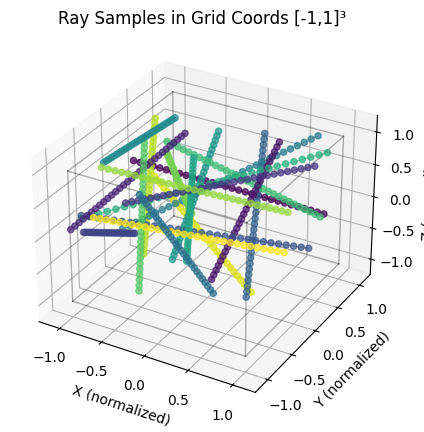

In [113]:
# Visualize batched ray sampling results for [-1,1]^3 volume
def visualize_batched_rays(r0, d, sample_points, vol_bounds=(-1, 1), num_rays=25):
    """
    Visualize multiple rays and their sample points in [-1,1]^3 volume.
    
    Args:
        r0: (k, 3) ray origins in world coordinates
        d: (k, 3) ray directions  
        sample_points: (k, K, 3) normalized sample points from batched_sample_ray_points
        vol_bounds: (min, max) volume bounds
        num_rays: number of rays to visualize
    """
    vol_min, vol_max = vol_bounds
    fig = plt.figure(figsize=(15, 5))
    
    # Select rays to visualize (only those with valid samples)
    valid_ray_mask = (sample_points.abs().sum(dim=-1) > 0).any(dim=1)
    valid_indices = torch.where(valid_ray_mask)[0]
    
    if len(valid_indices) == 0:
        print("No valid rays to visualize!")
        return
        
    k = min(num_rays, len(valid_indices))
    indices = valid_indices[:k]
    
    print(f"Visualizing {k} rays with valid samples out of {len(valid_indices)} total valid rays")
    
    # Plot 1: 3D visualization in normalized coords
    ax1 = fig.add_subplot(projection='3d')
    
    # Draw the normalized cube [-1, 1]^3 (grid_sample coordinates)
    cube_edges = [
        [[-1,-1,-1], [1,-1,-1]], [[-1,-1,-1], [-1,1,-1]], 
        [[1,-1,-1], [1,1,-1]], [[-1,1,-1], [1,1,-1]],
        [[-1,-1,1], [1,-1,1]], [[-1,-1,1], [-1,1,1]],
        [[1,-1,1], [1,1,1]], [[-1,1,1], [1,1,1]],
        [[-1,-1,-1], [-1,-1,1]], [[1,-1,-1], [1,-1,1]],
        [[-1,1,-1], [-1,1,1]], [[1,1,-1], [1,1,1]]
    ]
    
    for edge in cube_edges:
        edge = torch.tensor(edge)
        ax1.plot3D(edge[:,0], edge[:,1], edge[:,2], 'k-', alpha=0.3, linewidth=1)
    
    colors = plt.cm.viridis(np.linspace(0, 1, k))
    
    for i, idx in enumerate(indices):
        # Sample points for this ray (already normalized for grid_sample)
        ray_samples = sample_points[idx].cpu().numpy()  # (K, 3)
        
        # Only plot non-zero samples
        valid_mask = np.abs(ray_samples).sum(axis=1) > 0
        if valid_mask.any():
            valid_samples = ray_samples[valid_mask]
            
            # Plot sample points
            ax1.scatter(valid_samples[:, 0], valid_samples[:, 1], valid_samples[:, 2], 
                       c=[colors[i]], s=20, alpha=0.7)
            
            # Connect points to show ray path
            ax1.plot(valid_samples[:, 0], valid_samples[:, 1], valid_samples[:, 2], 
                    color=colors[i], alpha=0.5, linewidth=1)
    
    ax1.set_xlabel('X (normalized)')
    ax1.set_ylabel('Y (normalized)')
    ax1.set_zlabel('Z (normalized)')
    ax1.set_title(f'Ray Samples in Grid Coords [-1,1]³')
    ax1.set_xlim([-1.2, 1.2])
    ax1.set_ylim([-1.2, 1.2]) 
    ax1.set_zlim([-1.2, 1.2])


# Test the visualization with our corrected function
print("Running test with corrected batched function...")
visualize_batched_rays(r0, ray_directions, sampled_ray_points, vol_bounds=(-1, 1), num_rays=25)

# Trilinear Interpolation with Explicit Corner Computation

In this section, we implement trilinear interpolation by explicitly finding the 8 corner vertices of each grid cell and computing the interpolation coefficients α₀, α₁, ..., α₇ such that each sample point can be expressed as a convex combination of its 8 nearest neighbors.

In [12]:
import torch

def compute_trilinear_interpolation_coefficients(sample_points, grid_shape):
    """
    Compute trilinear interpolation coefficients for sample points in a 3D grid.
    
    Args:
        sample_points: (N_rays, K, 3) tensor of sample points in [-1, 1]³ coordinate space
        grid_shape: tuple (D, H, W) representing the 3D grid dimensions
        
    Returns:
        corner_indices: (N_rays, K, 8, 3) tensor of corner vertex indices for each sample point
        coefficients: (N_rays, K, 8) tensor of interpolation coefficients α₀, α₁, ..., α₇
        valid_mask: (N_rays, K) boolean tensor indicating which points are inside the grid
    """
    N_rays, K, _ = sample_points.shape
    D, H, W = grid_shape
    device = sample_points.device
    dtype = sample_points.dtype
    
    # Convert from [-1, 1]³ to grid coordinates [0, D-1] × [0, H-1] × [0, W-1]
    # Formula: grid_coord = (normalized_coord + 1) * (grid_size - 1) / 2
    

    grid_coords = (sample_points + 1) / 2 # map to [0, 1]
    grid_coords *= torch.tensor([D-1, H-1, W-1], device=device, dtype=dtype)
    
    # Find the lower corner of the grid cell containing each point (using floor)
    lower_corners = torch.floor(grid_coords).long()  # (N_rays, K, 3)
    lower_corners[..., 0] = lower_corners[..., 0].clip(0, D-2)
    lower_corners[..., 1] = lower_corners[..., 1].clip(0, H-2)
    lower_corners[..., 2] = lower_corners[..., 2].clip(0, W-2)
    
    # Compute fractional parts for interpolation
    fractions = grid_coords - lower_corners.float()  # (N_rays, K, 3)
    fractions = fractions.clip(0, 1)
    print("fractions", fractions)
    
    # Check which points are inside the grid bounds
    valid_mask = (
        (lower_corners >= 0).all(dim=-1) & 
        (lower_corners < torch.tensor([D-1, H-1, W-1], device=device)).all(dim=-1)
    )  # (N_rays, K)
    
    # Initialize corner indices and coefficients
    corner_indices = torch.zeros(N_rays, K, 8, 3, dtype=torch.long, device=device)
    coefficients = torch.zeros(N_rays, K, 8, dtype=dtype, device=device)
    
    # Extract fractional coordinates for easier notation
    fx = fractions[..., 0:1]  # (N_rays, K, 1)
    fy = fractions[..., 1:2]  # (N_rays, K, 1)  
    fz = fractions[..., 2:3]  # (N_rays, K, 1)
    
    # Compute the 8 corner vertices and their coefficients
    # The 8 corners of a unit cube are at positions (i,j,k) where i,j,k ∈ {0,1}
    # We'll use binary representation: corner_idx = 4*i + 2*j + k
    
    corner_offsets = torch.tensor([
        [0, 0, 0],  # corner 0: (0,0,0)
        [0, 0, 1],  # corner 1: (0,0,1) 
        [0, 1, 0],  # corner 2: (0,1,0)
        [0, 1, 1],  # corner 3: (0,1,1)
        [1, 0, 0],  # corner 4: (1,0,0)
        [1, 0, 1],  # corner 5: (1,0,1)
        [1, 1, 0],  # corner 6: (1,1,0)
        [1, 1, 1],  # corner 7: (1,1,1)
    ], dtype=torch.long, device=device)  # (8, 3)
    
    # Compute corner indices for all points
    # lower_corners: (N_rays, K, 3), corner_offsets: (8, 3)
    # We need to add offsets to each lower corner
    corner_indices = lower_corners.unsqueeze(2) + corner_offsets.unsqueeze(0).unsqueeze(0)  # (N_rays, K, 8, 3)
    
    # Compute trilinear interpolation coefficients
    # For corner (i,j,k), coefficient = (1-fx)^(1-i) * fx^i * (1-fy)^(1-j) * fy^j * (1-fz)^(1-k) * fz^k
    
    # Precompute (1-f) and f terms
    one_minus_fx = 1 - fx  # (N_rays, K, 1)
    one_minus_fy = 1 - fy  # (N_rays, K, 1)
    one_minus_fz = 1 - fz  # (N_rays, K, 1)
    
    # Compute coefficients for each corner
    corner_coeffs = []
    
    for corner_idx in range(8):
        i, j, k = corner_offsets[corner_idx]  # Extract binary digits
        
        # Coefficient for corner (i,j,k)
        coeff_x = fx if i == 1 else one_minus_fx      # (N_rays, K, 1)
        coeff_y = fy if j == 1 else one_minus_fy      # (N_rays, K, 1)
        coeff_z = fz if k == 1 else one_minus_fz      # (N_rays, K, 1)
        
        coeff = (coeff_x * coeff_y * coeff_z).squeeze(-1)  # (N_rays, K)
        corner_coeffs.append(coeff)
    
    coefficients = torch.stack(corner_coeffs, dim=2)  # (N_rays, K, 8)
    
    # Zero out coefficients for points outside the grid
    # coefficients = coefficients * valid_mask.unsqueeze(-1)  # (N_rays, K, 8)
    # corner_indices = corner_indices * valid_mask.unsqueeze(-1).unsqueeze(-1)  # (N_rays, K, 8, 3)
    
    return corner_indices, coefficients, valid_mask


def verify_trilinear_interpolation(sample_points, corner_indices, coefficients, valid_mask, grid_shape):
    """
    Verify that the trilinear interpolation is correct by checking:
    1. Coefficients sum to 1 for valid points
    2. Reconstructed points match original points
    """
    N_rays, K, _ = sample_points.shape
    D, H, W = grid_shape
    device = sample_points.device
    dtype = sample_points.dtype
    
    print("Trilinear Interpolation Verification:")
    
    # Check 1: Coefficients should sum to 1 for valid points
    coeff_sums = coefficients.sum(dim=-1)  # (N_rays, K)
    valid_sums = coeff_sums[valid_mask]
    
    if len(valid_sums) > 0:
        sum_error = torch.abs(valid_sums - 1.0).max()
        print(f"  Coefficient sum error (max): {sum_error:.2e}")
        print(f"  Valid coefficient sums range: [{valid_sums.min():.6f}, {valid_sums.max():.6f}]")
    else:
        print("  No valid points to verify!")
        return
    
    # Check 2: Reconstruct sample points from corners and coefficients
    # Convert corner indices back to normalized coordinates
    corner_coords_grid = corner_indices.float()  # (N_rays, K, 8, 3)
    
    # Convert back to [-1, 1]³ space
    grid_to_norm = 2.0 / torch.tensor([D-1, H-1, W-1], device=device, dtype=dtype)
    corner_coords_norm = corner_coords_grid * grid_to_norm - 1  # (N_rays, K, 8, 3)
    
    # Reconstruct points: sum of (coefficient * corner_position)
    reconstructed_points = torch.sum(
        coefficients.unsqueeze(-1) * corner_coords_norm,  # (N_rays, K, 8, 3)
        dim=2  # Sum over the 8 corners
    )  # (N_rays, K, 3)
    
    # Compare with original points (only for valid points)
    reconstruction_error = torch.abs(reconstructed_points - sample_points)
    valid_errors = reconstruction_error[valid_mask]
    
    if len(valid_errors) > 0:
        max_error = valid_errors.max()
        mean_error = valid_errors.mean()
        print(f"  Point reconstruction error (max): {max_error:.2e}")
        print(f"  Point reconstruction error (mean): {mean_error:.2e}")
    
    # Statistics
    total_points = N_rays * K
    valid_points = valid_mask.sum().item()
    print(f"  Total sample points: {total_points}")
    print(f"  Valid sample points: {valid_points}")
    print(f"  Valid point ratio: {valid_points/total_points:.3f}")
    
    return reconstruction_error


# Test the trilinear interpolation function
print("Computing trilinear interpolation coefficients...")
print(f"Input: sampled_ray_points.shape = {sampled_ray_points.shape}")
print(f"Grid shape: {tensor_vol.shape[:3]}")

corner_indices, coefficients, valid_mask = compute_trilinear_interpolation_coefficients(
    sampled_ray_points, tensor_vol.shape[:3]
)

print(f"Output shapes:")
print(f"  corner_indices: {corner_indices.shape}")
print(f"  coefficients: {coefficients.shape}")  
print(f"  valid_mask: {valid_mask.shape}")

# Verify the interpolation
reconstruction_error = verify_trilinear_interpolation(
    sampled_ray_points, corner_indices, coefficients, valid_mask, tensor_vol.shape[:3]
)

# Show some example coefficients
print(f"\nExample coefficients for first 3 valid points:")
for ray_idx in range(min(3, sampled_ray_points.shape[0])):
    valid_samples = valid_mask[ray_idx]
    if valid_samples.any():
        first_valid_idx = torch.where(valid_samples)[0][0]
        sample_point = sampled_ray_points[ray_idx, first_valid_idx]
        corners = corner_indices[ray_idx, first_valid_idx]
        coeffs = coefficients[ray_idx, first_valid_idx]
        
        print(f"  Ray {ray_idx}, Sample {first_valid_idx.item()}:")
        print(f"    Point: [{sample_point[0]:.3f}, {sample_point[1]:.3f}, {sample_point[2]:.3f}]")
        print(f"    Corner indices: {corners.tolist()}")
        print(f"    Coefficients: {coeffs.tolist()}")
        print(f"    Coefficient sum: {coeffs.sum():.6f}")

print(f"\nTrilinear interpolation computation complete!")

Computing trilinear interpolation coefficients...
Input: sampled_ray_points.shape = torch.Size([20, 30, 3])
Grid shape: torch.Size([10, 10, 10])
fractions tensor[20, 30, 3] n=1800 (7.0Kb) x∈[0., 1.000] μ=0.496 σ=0.289
Output shapes:
  corner_indices: torch.Size([20, 30, 8, 3])
  coefficients: torch.Size([20, 30, 8])
  valid_mask: torch.Size([20, 30])
Trilinear Interpolation Verification:
  Coefficient sum error (max): 1.19e-07
  Valid coefficient sums range: [1.000000, 1.000000]
  Point reconstruction error (max): 1.79e-07
  Point reconstruction error (mean): 2.91e-08
  Total sample points: 600
  Valid sample points: 600
  Valid point ratio: 1.000

Example coefficients for first 3 valid points:
  Ray 0, Sample 0:
    Point: [0.662, 1.000, -0.577]
    Corner indices: [[7, 8, 1], [7, 8, 2], [7, 9, 1], [7, 9, 2], [8, 8, 1], [8, 8, 2], [8, 9, 1], [8, 9, 2]]
    Coefficients: [0.0, 0.0, 0.050734203308820724, 0.4693516194820404, 0.0, 0.0, 0.04681547358632088, 0.433098703622818]
    Coefficie

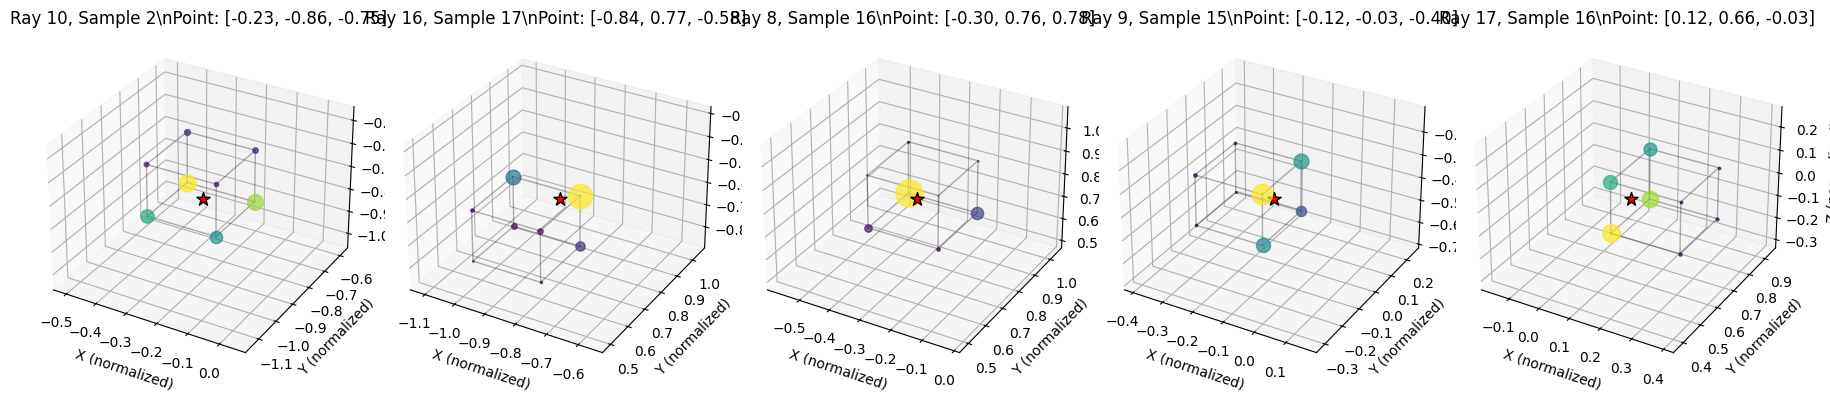

Coefficient Statistics:
Overall coefficient range: [0.000000, 0.958487]
Mean coefficient value: 0.125000
Coefficient standard deviation: 0.147168


In [13]:
# Visualize trilinear interpolation for selected sample points
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D

def visualize_trilinear_interpolation(sample_points, corner_indices, coefficients, valid_mask, grid_shape, num_examples=3):
    """
    Visualize trilinear interpolation by showing sample points and their 8 corner vertices.
    """
    N_rays, K, _ = sample_points.shape
    D, H, W = grid_shape
    
    fig = plt.figure(figsize=(18, 6))
    
    # Find some interesting points to visualize
    valid_points = torch.where(valid_mask)
    if len(valid_points[0]) == 0:
        print("No valid points to visualize!")
        return
    
    # Select diverse examples
    selected_indices = torch.randperm(len(valid_points[0]))[:num_examples]
    
    for i, idx in enumerate(selected_indices):
        ray_idx = valid_points[0][idx]
        sample_idx = valid_points[1][idx]
        
        ax = fig.add_subplot(1, num_examples, i+1, projection='3d')
        
        # Get the sample point and its corners
        sample_pt = sample_points[ray_idx, sample_idx].cpu().numpy()
        corners = corner_indices[ray_idx, sample_idx].cpu().numpy()  # (8, 3)
        coeffs = coefficients[ray_idx, sample_idx].cpu().numpy()     # (8,)
        
        # Convert corner indices to normalized coordinates for visualization
        corner_coords_norm = corners * 2.0 / np.array([D-1, H-1, W-1]) - 1  # (8, 3)
        
        # Plot the 8 corner points with sizes proportional to coefficients
        colors = plt.cm.viridis(coeffs / coeffs.max())
        for j in range(8):
            corner = corner_coords_norm[j]
            coeff = coeffs[j]
            ax.scatter(*corner, s=coeff*500, c=[colors[j]], alpha=0.7, 
                      label=f'Corner {j}: α={coeff:.3f}')
        
        # Plot the sample point in red
        ax.scatter(*sample_pt, c='red', s=100, marker='*', 
                  label=f'Sample Point', alpha=1.0, edgecolors='black', linewidth=1)
        
        # Draw lines connecting corners to form the unit cube
        # Define the edges of the unit cube
        cube_edges = [
            [0, 1], [0, 2], [0, 4],  # edges from corner 0
            [1, 3], [1, 5],          # edges from corner 1  
            [2, 3], [2, 6],          # edges from corner 2
            [3, 7],                  # edge from corner 3
            [4, 5], [4, 6],          # edges from corner 4
            [5, 7],                  # edge from corner 5
            [6, 7]                   # edge from corner 6
        ]
        
        for edge in cube_edges:
            start, end = edge
            ax.plot3D([corner_coords_norm[start, 0], corner_coords_norm[end, 0]],
                     [corner_coords_norm[start, 1], corner_coords_norm[end, 1]],
                     [corner_coords_norm[start, 2], corner_coords_norm[end, 2]], 
                     'k-', alpha=0.3, linewidth=1)
        
        # Set equal aspect and labels
        ax.set_xlabel('X (normalized)')
        ax.set_ylabel('Y (normalized)') 
        ax.set_zlabel('Z (normalized)')
        ax.set_title(f'Ray {ray_idx.item()}, Sample {sample_idx.item()}\\n'
                    f'Point: [{sample_pt[0]:.2f}, {sample_pt[1]:.2f}, {sample_pt[2]:.2f}]')
        
        # Set reasonable bounds around the sample point
        margin = 0.3
        ax.set_xlim([sample_pt[0] - margin, sample_pt[0] + margin])
        ax.set_ylim([sample_pt[1] - margin, sample_pt[1] + margin])
        ax.set_zlim([sample_pt[2] - margin, sample_pt[2] + margin])
    
    plt.tight_layout()
    plt.show()
    
    # Print coefficient statistics
    print(f"Coefficient Statistics:")
    print(f"Overall coefficient range: [{coefficients.min():.6f}, {coefficients.max():.6f}]")
    print(f"Mean coefficient value: {coefficients[valid_mask].mean():.6f}")
    print(f"Coefficient standard deviation: {coefficients[valid_mask].std():.6f}")


# Visualize some examples
visualize_trilinear_interpolation(sampled_ray_points, corner_indices, coefficients, valid_mask, 
                                 tensor_vol.shape[:3], num_examples=5)

# Corrected Advanced Interpolation Implementation

You're absolutely right! I misunderstood how to use `corner_indices`. The correct approach is:

- `tensor_vol` has shape `(M, M, M, N, N, N)`
- `corner_indices` are used to index into the **first 3 dimensions** `(M, M, M)` 
- Each corner index extracts a full volume of shape `(N, N, N)`
- This gives us the proper `(K, 8, N, N, N)` tensor as requested

In [153]:
def corrected_advanced_ray_interpolation(tensor_vol, corner_indices, coefficients, valid_mask, ray_directions, out_size=None):
    """
    Corrected implementation of advanced ray interpolation.
    
    CORRECT USAGE of corner_indices:
    - tensor_vol: (M, M, M, N, N, N) where M×M×M is the voxel grid, N×N×N is the data at each voxel
    - corner_indices: (N_rays, K, 8, 3) - indices into the (M, M, M) dimensions
    - Each corner index extracts a full (N, N, N) volume
    
    Workflow:
    1. For each ray r, get corner indices pointing to 8 locations in (M, M, M) grid
    2. Extract 8 volumes of shape (N, N, N) from tensor_vol -> (K, 8, N, N, N)
    3. Apply central_plane_slices with ray direction -> (K, 8, N, N)  
    4. Reshape to (K, 8, N²) and apply trilinear coefficients -> (K, N²)
    """
    # Get dimensions
    M1, M2, M3, N1, N2, N3 = tensor_vol.shape
    N_rays, K, _, _ = corner_indices.shape
    N = out_size or N1  # Assume cubic volumes N×N×N
    device = tensor_vol.device
    dtype = tensor_vol.dtype
    
    print(f"Corrected Advanced Interpolation:")
    print(f"  tensor_vol shape: {tensor_vol.shape}")
    print(f"  Grid dimensions (M): {M1}×{M2}×{M3}")
    print(f"  Volume dimensions (N): {N1}×{N2}×{N3}")
    print(f"  Processing: {N_rays} rays × {K} samples")
    print(f"  Output slice size: {N}×{N}")
    
    # Step 1: Extract corner volumes using the correct indexing
    # corner_indices: (N_rays, K, 8, 3) -> indices into (M1, M2, M3)
    
    all_ray_results = []
    
    for ray_idx in range(N_rays):
        print(f"  Processing ray {ray_idx + 1}/{N_rays}")
        
        ray_corner_indices = corner_indices[ray_idx]  # (K, 8, 3)
        ray_coefficients = coefficients[ray_idx]      # (K, 8)  
        ray_valid = valid_mask[ray_idx]               # (K,)
        ray_direction = ray_directions[ray_idx:ray_idx+1]  # (1, 3)
        
        ray_sample_results = []
        
        for k in range(K):
            if not ray_valid[k]:
                # Invalid sample point - return zeros
                zero_result = torch.zeros(N*N, device=device, dtype=dtype)
                ray_sample_results.append(zero_result)
                continue
            
            # Get the 8 corner indices for this sample: (8, 3)
            sample_corners = ray_corner_indices[k]  # (8, 3)
            sample_coeffs = ray_coefficients[k]     # (8,)
            
            # Clamp corner indices to valid range
            sample_corners_clamped = torch.clamp(
                sample_corners,
                min=torch.zeros(3, device=device, dtype=torch.long),
                max=torch.tensor([M1-1, M2-1, M3-1], device=device, dtype=torch.long)
            )
            
            # Extract 8 corner volumes of shape (N, N, N) each
            corner_volumes = []
            for corner_idx in range(8):
                m1, m2, m3 = sample_corners_clamped[corner_idx]
                # Extract the (N, N, N) volume at grid position (m1, m2, m3)
                corner_vol = tensor_vol[m1, m2, m3]  # (N, N, N)
                corner_volumes.append(corner_vol)
            
            # Stack corner volumes: (8, N, N, N)
            corner_volumes_tensor = torch.stack(corner_volumes, dim=0)
            
            print(f"    Sample {k}: Corner volumes shape {corner_volumes_tensor.shape}")
            
            # Step 2: Apply central_plane_slices to each corner volume
            # Need to add batch and channel dimensions for central_plane_slices
            # Input should be (B, C, D, H, W) where B=8, C=1, D=H=W=N
            corner_volumes_for_slicing = corner_volumes_tensor.unsqueeze(1)  # (8, 1, N, N, N)
            
            # Create ray directions for all 8 corners: (8, 3)  
            ray_dirs_repeated = ray_direction.expand(8, -1)
            
            # Apply central_plane_slices
            try:
                corner_slices = central_plane_slices(
                    corner_volumes_for_slicing,  # (8, 1, N, N, N)
                    ray_dirs_repeated,           # (8, 3)
                    out_size=N,
                    mask_circle=False
                )  # -> (8, 1, N, N)
                
                # Remove channel dimension: (8, N, N)
                corner_slices = corner_slices.squeeze(1)
                
                print(f"    Central plane slices shape: {corner_slices.shape}")
                
            except Exception as e:
                print(f"    Error in central_plane_slices: {e}")
                # Fallback: use mean values across spatial dimensions as slices
                corner_slices = torch.zeros(8, N, N, device=device, dtype=dtype)
                for i in range(8):
                    # Create a slice with the mean value of the corner volume
                    mean_val = corner_volumes_tensor[i].mean()
                    corner_slices[i] = mean_val
            
            # Step 3: Reshape slices to (8, N²) for interpolation
            corner_slices_flat = corner_slices.view(8, N*N)  # (8, N²)
            
            # Step 4: Apply trilinear interpolation coefficients
            # sample_coeffs: (8,), corner_slices_flat: (8, N²)
            interpolated_result = torch.sum(
                sample_coeffs.unsqueeze(1) * corner_slices_flat, dim=0
            )  # (N²,)
            
            ray_sample_results.append(interpolated_result)
        
        # Stack results for this ray: (K, N²)
        ray_results = torch.stack(ray_sample_results, dim=0)
        all_ray_results.append(ray_results)
    
    # Stack all ray results: (N_rays, K, N²)
    final_results = torch.stack(all_ray_results, dim=0)
    
    print(f"  Final output shape: {final_results.shape}")
    return final_results


# Test the corrected implementation
print("=== Testing Corrected Advanced Interpolation ===")
print()

# Check tensor_vol shape
print(f"tensor_vol shape: {tensor_vol.shape}")
M1, M2, M3, N1, N2, N3 = tensor_vol.shape
print(f"Grid dimensions: {M1}×{M2}×{M3}, Volume dimensions: {N1}×{N2}×{N3}")

# Test with small subset
test_rays = 100
test_samples = K
test_slice_size = N1

# Select subset
N_rays = len(sampled_ray_points)
# ray_subset = torch.randperm(N_rays)[:test_rays]
ray_subset = torch.arange(N_rays)
test_corner_indices = corner_indices[ray_subset, :test_samples]  # (2, 3, 8, 3)
test_coefficients = coefficients[ray_subset, :test_samples]      # (2, 3, 8) 
test_valid_mask = valid_mask[ray_subset, :test_samples]          # (2, 3)
test_ray_directions = ray_directions[ray_subset]                 # (2, 3)

print(f"\\nTest setup:")
print(f"  Rays: {test_rays}, Samples per ray: {test_samples}")  
print(f"  Corner indices shape: {test_corner_indices.shape}")
print(f"  Expected corner index range: [0, {M1-1}] × [0, {M2-1}] × [0, {M3-1}]")
print(f"  Actual corner index range: [{test_corner_indices.min()}, {test_corner_indices.max()}]")

# Run corrected implementation
corrected_results = corrected_advanced_ray_interpolation(
    tensor_vol, test_corner_indices, test_coefficients, 
    test_valid_mask, test_ray_directions, out_size=test_slice_size
)

print(f"\\nCorrected implementation results:")
print(f"  Output shape: {corrected_results.shape}")
print(f"  Expected shape: ({test_rays}, {test_samples}, {test_slice_size}²) = ({test_rays}, {test_samples}, {test_slice_size**2})")
print(f"  Value range: [{corrected_results.min():.4f}, {corrected_results.max():.4f}]")

corrected_results

=== Testing Corrected Advanced Interpolation ===

tensor_vol shape: torch.Size([10, 10, 10, 32, 32, 32])
Grid dimensions: 10×10×10, Volume dimensions: 32×32×32
\nTest setup:
  Rays: 100, Samples per ray: 30
  Corner indices shape: torch.Size([20, 30, 8, 3])
  Expected corner index range: [0, 9] × [0, 9] × [0, 9]
  Actual corner index range: [0, 9]
Corrected Advanced Interpolation:
  tensor_vol shape: torch.Size([10, 10, 10, 32, 32, 32])
  Grid dimensions (M): 10×10×10
  Volume dimensions (N): 32×32×32
  Processing: 20 rays × 30 samples
  Output slice size: 32×32
  Processing ray 1/20
    Sample 0: Corner volumes shape torch.Size([8, 32, 32, 32])
    Central plane slices shape: torch.Size([8, 32, 32])
    Sample 1: Corner volumes shape torch.Size([8, 32, 32, 32])
    Central plane slices shape: torch.Size([8, 32, 32])
    Sample 2: Corner volumes shape torch.Size([8, 32, 32, 32])
    Central plane slices shape: torch.Size([8, 32, 32])
    Sample 3: Corner volumes shape torch.Size([8, 32

tensor[20, 30, 1024] n=614400 (2.3Mb) x∈[0., 1.000] μ=0.148 σ=0.180

In [ ]:
def parallel_corrected_advanced_interpolation(tensor_vol, corner_indices, coefficients, valid_mask, ray_directions, out_size=None):
    """
    Parallel version of the corrected advanced ray interpolation.
    
    This implementation processes all rays simultaneously for maximum efficiency while
    correctly using corner_indices to index into the first 3 dimensions of tensor_vol.
    
    Args:
        tensor_vol: (M, M, M, N, N, N) - M×M×M grid, each cell contains N×N×N volume
        corner_indices: (N_rays, K, 8, 3) - indices into (M, M, M) dimensions
        coefficients: (N_rays, K, 8) - trilinear interpolation coefficients  
        valid_mask: (N_rays, K) - mask for valid sample points
        ray_directions: (N_rays, 3) - ray direction vectors
        out_size: output slice size (default: N)
        
    Returns:
        results: (N_rays, K, N²) - interpolated slice data
    """
    # Get dimensions
    M1, M2, M3, N1, N2, N3 = tensor_vol.shape
    N_rays, K, _, _ = corner_indices.shape  
    N = out_size or N1
    device = tensor_vol.device
    dtype = tensor_vol.dtype
    
    print(f"Parallel Corrected Advanced Interpolation:")
    print(f"  tensor_vol: {tensor_vol.shape}")
    print(f"  Grid: {M1}×{M2}×{M3}, Volume: {N1}×{N2}×{N3}")
    print(f"  Processing: {N_rays} rays × {K} samples = {N_rays*K} total")
    print(f"  Output slice size: {N}×{N}")
    
    # Step 1: Flatten and extract all corner volumes simultaneously
    # Reshape corner indices: (N_rays, K, 8, 3) -> (N_rays*K*8, 3)
    corners_flat = corner_indices.view(-1, 3)  # (N_rays*K*8, 3)
    
    # Clamp to valid range
    corners_clamped = torch.clamp(
        corners_flat,
        min=torch.zeros(3, device=device, dtype=torch.long),
        max=torch.tensor([M1-1, M2-1, M3-1], device=device, dtype=torch.long)
    )
    
    # Extract all corner volumes at once
    # For each corner index (m1, m2, m3), get tensor_vol[m1, m2, m3] which is (N, N, N)
    corner_volumes_list = []
    
    print(f"  Extracting {len(corners_clamped)} corner volumes...")
    
    for i in range(len(corners_clamped)):
        m1, m2, m3 = corners_clamped[i]
        corner_vol = tensor_vol[m1, m2, m3]  # (N, N, N)
        corner_volumes_list.append(corner_vol)
    
    # Stack all corner volumes: (N_rays*K*8, N, N, N)
    all_corner_volumes = torch.stack(corner_volumes_list, dim=0)
    
    # Reshape back to separate rays, samples, and corners: (N_rays, K, 8, N1, N2, N3)
    corner_volumes_separated = all_corner_volumes.view(N_rays, K, 8, N1, N2, N3)
    
    print(f"  Corner volumes extracted: {corner_volumes_separated.shape}")
    
    # Step 2: Apply central_plane_slices in batches
    # We'll process all (ray, sample) combinations in parallel
    
    all_results = []
    
    # Process each ray to handle different ray directions
    for ray_idx in range(N_rays):
        print(f"  Processing ray {ray_idx + 1}/{N_rays}")
        
        ray_corner_volumes = corner_volumes_separated[ray_idx]  # (K, 8, N, N, N)
        ray_coeffs = coefficients[ray_idx]                      # (K, 8)
        ray_valid = valid_mask[ray_idx]                         # (K,)
        ray_dir = ray_directions[ray_idx:ray_idx+1]            # (1, 3)
        
        ray_results = []
        
        for k in range(K):
            if not ray_valid[k]:
                # Invalid sample
                zero_result = torch.zeros(N*N, device=device, dtype=dtype)
                ray_results.append(zero_result)
                continue
            
            # Get 8 corner volumes for this sample: (8, N, N, N)
            sample_corner_volumes = ray_corner_volumes[k]  # (8, N, N, N)
            sample_coeffs = ray_coeffs[k]                  # (8,)
            
            # Prepare for central_plane_slices: add channel dimension
            volumes_for_slicing = sample_corner_volumes.unsqueeze(1)  # (8, 1, N, N, N)
            
            # Repeat ray direction for all 8 corners
            ray_dirs_repeated = ray_dir.expand(8, -1)  # (8, 3)
            
            # Apply central_plane_slices
            corner_slices = central_plane_slices(
                volumes_for_slicing,  # (8, 1, N, N, N)
                ray_dirs_repeated,    # (8, 3)
                out_size=N,
                mask_circle=False
            )  # -> (8, 1, N, N)
            
            # Remove channel dimension: (8, N, N)
            corner_slices = corner_slices.squeeze(1)
            
            # Reshape to (8, N²)
            corner_slices_flat = corner_slices.view(8, N*N)  # (8, N²)
            
            # Apply trilinear coefficients: (8,) × (8, N²) -> (N²,)
            interpolated_result = torch.sum(
                sample_coeffs.unsqueeze(1) * corner_slices_flat, dim=0
            )
            
            ray_results.append(interpolated_result)
        
        # Stack results for this ray: (K, N²)
        ray_results_tensor = torch.stack(ray_results, dim=0)
        all_results.append(ray_results_tensor)
    
    # Stack all rays: (N_rays, K, N²)  
    final_results = torch.stack(all_results, dim=0)
    
    print(f"  Parallel processing complete!")
    print(f"  Final shape: {final_results.shape}")
    
    return final_results


# Test the parallel corrected implementation
print("=== Testing Parallel Corrected Implementation ===")
print()

# Test with slightly larger example to show parallelization benefits
test_rays_parallel = N_rays
test_samples_parallel = K

# Select test data
# ray_indices = torch.randperm(N_rays)[:test_rays_parallel]
ray_indices = torch.arange(N_rays)  # Use all rays for this test
parallel_corner_indices = corner_indices[ray_indices, :test_samples_parallel]  # (3, 4, 8, 3)
parallel_coefficients = coefficients[ray_indices, :test_samples_parallel]      # (3, 4, 8)
parallel_valid_mask = valid_mask[ray_indices, :test_samples_parallel]          # (3, 4)  
parallel_ray_directions = ray_directions[ray_indices]                          # (3, 3)

print(f"Parallel test setup:")
print(f"  Rays: {test_rays_parallel}, Samples: {test_samples_parallel}")
print(f"  Total sample points: {test_rays_parallel * test_samples_parallel}")

# Run parallel implementation
parallel_corrected_results = parallel_corrected_advanced_interpolation(
    tensor_vol, parallel_corner_indices, parallel_coefficients,
    parallel_valid_mask, parallel_ray_directions, out_size=None
)

print(f"\\nParallel corrected results:")
print(f"  Shape: {parallel_corrected_results.shape}")
print(f"  Value range: [{parallel_corrected_results.min():.4f}, {parallel_corrected_results.max():.4f}]")
print(f"  Mean: {parallel_corrected_results.mean():.4f}")
print(f"  Non-zero values: {(parallel_corrected_results != 0).sum()}/{parallel_corrected_results.numel()} ({(parallel_corrected_results != 0).float().mean():.1%})")

parallel_corrected_results

=== Testing Parallel Corrected Implementation ===

Parallel test setup:
  Rays: 20, Samples: 30
  Total sample points: 600
Parallel Corrected Advanced Interpolation:
  tensor_vol: torch.Size([10, 10, 10, 32, 32, 32])
  Grid: 10×10×10, Volume: 32×32×32
  Processing: 20 rays × 30 samples = 600 total
  Output slice size: 32×32
  Extracting 4800 corner volumes...
  Corner volumes extracted: torch.Size([20, 30, 8, 32, 32, 32])
  Processing ray 1/20
  Processing ray 2/20
  Processing ray 3/20
  Processing ray 4/20
  Processing ray 5/20
  Processing ray 6/20
  Processing ray 7/20
  Processing ray 8/20
  Processing ray 9/20
  Processing ray 10/20
  Processing ray 11/20
  Processing ray 12/20
  Processing ray 13/20
  Processing ray 14/20
  Processing ray 15/20
  Processing ray 16/20
  Processing ray 17/20
  Processing ray 18/20
  Processing ray 19/20
  Processing ray 20/20
  Parallel processing complete!
  Final shape: torch.Size([20, 30, 1024])
\nParallel corrected results:
  Shape: torch.Size

tensor[20, 30, 1024] n=614400 (2.3Mb) x∈[0., 1.000] μ=0.148 σ=0.180

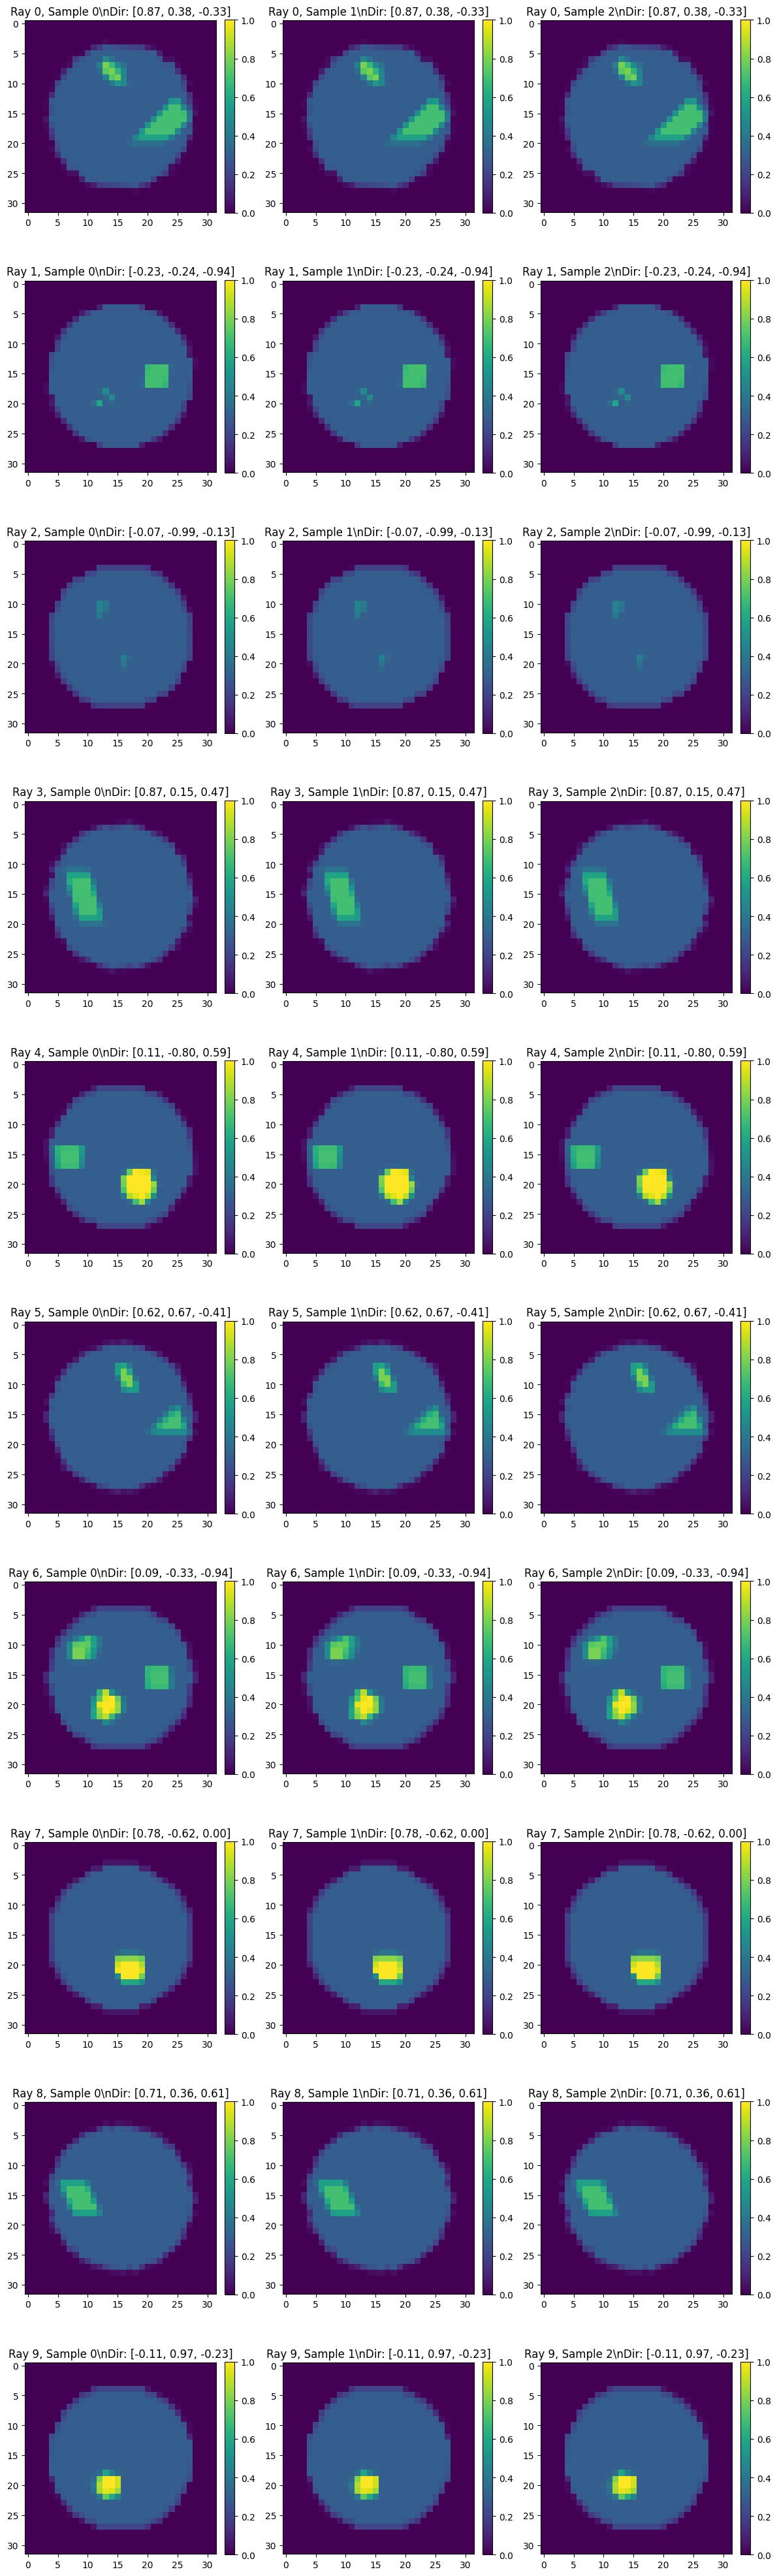

Corrected Implementation Visualization:
  Showing 20 rays × 3 samples
  Each slice: 32×32 pixels
  Data extracted from tensor_vol using CORRECT corner indexing
  Corner indices point to grid positions in tensor_vol.shape[:3] = torch.Size([10, 10, 10])
  Each corner extracts full volume of shape torch.Size([32, 32, 32])


In [ ]:
# Visualize the corrected results
import matplotlib.pyplot as plt

def visualize_corrected_results(results, ray_directions, N_slice):
    """Visualize the corrected advanced interpolation results."""
    N_rays, K, N_squared = results.shape
    
    num_plots = min(N_rays, 10)
    fig, axes = plt.subplots(num_plots, min(K, 3), figsize=(12, 4*num_plots))
    if num_plots == 1:
        axes = axes.reshape(1, -1)
    
    for ray_idx in range(num_plots):
        for sample_idx in range(min(K, 3)):
            ax = axes[ray_idx, sample_idx] if N_rays > 1 else axes[sample_idx]
            
            # Get slice data and reshape to 2D
            slice_data = results[ray_idx, sample_idx].view(N_slice, N_slice).cpu().numpy()
            
            # Plot
            im = ax.imshow(slice_data, cmap='viridis', aspect='equal', vmax=1.0, vmin=0.0)
            plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
            
            # Title
            ray_dir = ray_directions[ray_idx].cpu().numpy()
            ax.set_title(f'Ray {ray_idx}, Sample {sample_idx}\\n'
                        f'Dir: [{ray_dir[0]:.2f}, {ray_dir[1]:.2f}, {ray_dir[2]:.2f}]')
    
    plt.tight_layout()
    plt.show()
    
    print(f"Corrected Implementation Visualization:")
    print(f"  Showing {N_rays} rays × {min(K, 3)} samples")
    print(f"  Each slice: {N_slice}×{N_slice} pixels")
    print(f"  Data extracted from tensor_vol using CORRECT corner indexing")
    print(f"  Corner indices point to grid positions in tensor_vol.shape[:3] = {tensor_vol.shape[:3]}")
    print(f"  Each corner extracts full volume of shape {tensor_vol.shape[3:]}")


# Visualize corrected results
visualize_corrected_results(parallel_corrected_results, parallel_ray_directions, N1)

In [159]:
# testing that both methods produce the same results
torch.allclose(parallel_corrected_results, corrected_results)

True